In [1]:
# Import Libraries
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

In [2]:
class ParrEstimator:
    def __init__(self):
        self.percent_parr = ctrl.Antecedent(np.arange(0, 1.0, 0.01), 'percent_parr') # Percent of code that is parallelizable
        self.mag_runtime = ctrl.Antecedent(np.arange(0, 1.0, 0.01), 'mag_runtime') # Normalized magnitude with max runtime of 5 seconds
        self.parr_est_out = ctrl.Consequent(np.arange(0, 1, 0.01), 'parr_est_out') # Impact from 0-1 of code being paralellized
        self.max_mag = 5.0
        self.generate_mf()
    def generate_mf(self):
        # Generate fuzzy membership functions
        self.percent_parr['low'] = fuzz.trapmf(self.percent_parr.universe, [0, 0, 0.3, 0.4])
        self.percent_parr['medium'] = fuzz.gaussmf(self.percent_parr.universe, 0.5, 0.1)
        self.percent_parr['high'] = fuzz.trapmf(self.percent_parr.universe, [0.6, 0.7, 1.0, 1.0])
        self.percent_parr.view()
        self.mag_runtime['low'] = fuzz.trapmf(self.mag_runtime.universe, [0, 0, 0.3, 0.4])
        self.mag_runtime['medium'] = fuzz.gaussmf(self.mag_runtime.universe, 0.5, 0.1)
        self.mag_runtime['high'] = fuzz.trapmf(self.mag_runtime.universe, [0.6, 0.7, 1.0, 1.0])
        self.mag_runtime.view()
        self.parr_est_out['low'] = fuzz.trapmf(self.parr_est_out.universe, [0, 0, 0.3, 0.4])
        self.parr_est_out['medium'] = fuzz.gaussmf(self.parr_est_out.universe, 0.5, 0.1)
        self.parr_est_out['high'] = fuzz.trapmf(self.parr_est_out.universe, [0.6, 0.7, 1.0, 1.0])
        self.parr_est_out.view()
        self.generate_rules()
    def generate_rules(self):
        # Define the Rule Set
        self.rules = []
        self.rules.append(ctrl.Rule(self.percent_parr['low'] & self.mag_runtime['low'], self.parr_est_out['low']))
        self.rules.append(ctrl.Rule(self.percent_parr['low'] & self.mag_runtime['medium'], self.parr_est_out['low']))
        self.rules.append(ctrl.Rule(self.percent_parr['low'] & self.mag_runtime['high'], self.parr_est_out['low']))
        self.rules.append(ctrl.Rule(self.percent_parr['medium'] & self.mag_runtime['low'], self.parr_est_out['low']))
        self.rules.append(ctrl.Rule(self.percent_parr['medium'] & self.mag_runtime['medium'], self.parr_est_out['medium']))
        self.rules.append(ctrl.Rule(self.percent_parr['medium'] & self.mag_runtime['high'], self.parr_est_out['high']))
        self.rules.append(ctrl.Rule(self.percent_parr['high'] & self.mag_runtime['low'], self.parr_est_out['low']))
        self.rules.append(ctrl.Rule(self.percent_parr['high'] & self.mag_runtime['medium'], self.parr_est_out['high']))
        self.rules.append(ctrl.Rule(self.percent_parr['high'] & self.mag_runtime['high'], self.parr_est_out['high']))
        self.gen_ctrl_sys()
    def gen_ctrl_sys(self):
        # Create the control system
        self.parr_ctrl = ctrl.ControlSystem(self.rules)
        # Create the simulation for the control system
        self.parr_ctrl_sim = ctrl.ControlSystemSimulation(self.parr_ctrl)
    def calculate_parr_out(self,percent_parr,run_mag):
        self.parr_ctrl_sim.input['percent_parr'] = percent_parr
        self.parr_ctrl_sim.input['mag_runtime'] = run_mag/self.max_mag
        # Calculate the location
        self.parr_ctrl_sim.compute()
        return self.parr_ctrl_sim.output['parr_est_out']
        



In [3]:
class LatencyEffects:
    def __init__(self):
        self.latency = ctrl.Antecedent(np.arange(0, 1.0, 0.01), 'latency') # Normalized latency with max being 500ms
        self.latency_tol = ctrl.Antecedent(np.arange(0, 1.0, 0.01), 'latency_tol') # Value from 0-1 for realtime priority
        self.latency_est_out = ctrl.Consequent(np.arange(0, 1, 0.01), 'latency_est_out') # Impact to tolerance from 0-1
        self.max_lat = 500.0
        self.generate_mf()
    def generate_mf(self):
        # Generate fuzzy membership functions
        self.latency['low'] = fuzz.trapmf(self.latency.universe, [0, 0, 0.3, 0.4])
        self.latency['medium'] = fuzz.gaussmf(self.latency.universe, 0.5, 0.1)
        self.latency['high'] = fuzz.trapmf(self.latency.universe, [0.6, 0.7, 1.0, 1.0])
        self.latency.view()
        self.latency_tol['low'] = fuzz.trapmf(self.latency_tol.universe, [0, 0, 0.3, 0.4])
        self.latency_tol['medium'] = fuzz.gaussmf(self.latency_tol.universe, 0.5, 0.1)
        self.latency_tol['high'] = fuzz.trapmf(self.latency_tol.universe, [0.6, 0.7, 1.0, 1.0])
        self.latency_tol.view()
        self.latency_est_out['low'] = fuzz.trapmf(self.latency_est_out.universe, [0, 0, 0.3, 0.4])
        self.latency_est_out['medium'] = fuzz.gaussmf(self.latency_est_out.universe, 0.5, 0.1)
        self.latency_est_out['high'] = fuzz.trapmf(self.latency_est_out.universe, [0.6, 0.7, 1.0, 1.0])
        self.latency_est_out.view()
        self.generate_rules()
    def generate_rules(self):
        # Define the Rule Set
        self.rules = []
        self.rules.append(ctrl.Rule(self.latency['low'] & self.latency_tol['low'], self.latency_est_out['low']))
        self.rules.append(ctrl.Rule(self.latency['low'] & self.latency_tol['medium'], self.latency_est_out['low']))
        self.rules.append(ctrl.Rule(self.latency['low'] & self.latency_tol['high'], self.latency_est_out['low']))
        self.rules.append(ctrl.Rule(self.latency['medium'] & self.latency_tol['low'], self.latency_est_out['medium']))
        self.rules.append(ctrl.Rule(self.latency['medium'] & self.latency_tol['medium'], self.latency_est_out['low']))
        self.rules.append(ctrl.Rule(self.latency['medium'] & self.latency_tol['high'], self.latency_est_out['low']))
        self.rules.append(ctrl.Rule(self.latency['high'] & self.latency_tol['low'], self.latency_est_out['high']))
        self.rules.append(ctrl.Rule(self.latency['high'] & self.latency_tol['medium'], self.latency_est_out['high']))
        self.rules.append(ctrl.Rule(self.latency['high'] & self.latency_tol['high'], self.latency_est_out['low']))
        self.gen_ctrl_sys()
    def gen_ctrl_sys(self):
        # Create the control system
        self.lat_ctrl = ctrl.ControlSystem(self.rules)
        # Create the simulation for the control system
        self.lat_ctrl_sim = ctrl.ControlSystemSimulation(self.lat_ctrl)
    def calculate_lat_out(self,latency,latency_tol):
        self.lat_ctrl_sim.input['latency'] = latency/self.max_lat
        self.lat_ctrl_sim.input['latency_tol'] = latency_tol
        # Calculate the location
        self.lat_ctrl_sim.compute()
        return self.lat_ctrl_sim.output['latency_est_out']

In [4]:
class ContainerEstimator:
    def __init__(self):
        self.parr_est_block = ParrEstimator()
        self.lat_est_block = LatencyEffects()
        self.parr_est = ctrl.Antecedent(np.arange(0, 1.0, 0.01), 'parr_est') # Output from parr_est
        self.lat_est = ctrl.Antecedent(np.arange(0, 1.0, 0.01), 'lat_est') # Output from lat_est
        self.band_ratio = ctrl.Antecedent(np.arange(0, 1, 0.01), 'band_ratio') # Ratio of bandwidth/throughput, higher is better for cloud
        self.others_info = ctrl.Antecedent(np.arange(0, 1, 0.01), 'others_info') # Does the algorithm require info from other nodes
        self.container_loc = ctrl.Consequent(np.arange(0, 1, 0.01), 'container_loc') # Placement of container 0.0 end, 0.5 edge, 1.0 cloud
        self.generate_mf()
    def generate_mf(self):
        # Generate fuzzy membership functions
        self.parr_est['low'] = fuzz.trapmf(self.parr_est.universe, [0, 0, 0.3, 0.4])
        self.parr_est['medium'] = fuzz.gaussmf(self.parr_est.universe, 0.5, 0.1)
        self.parr_est['high'] = fuzz.trapmf(self.parr_est.universe, [0.6, 0.7, 1.0, 1.0])
        self.parr_est.view()
        self.lat_est['low'] = fuzz.trapmf(self.lat_est.universe, [0, 0, 0.3, 0.4])
        self.lat_est['medium'] = fuzz.gaussmf(self.lat_est.universe, 0.5, 0.1)
        self.lat_est['high'] = fuzz.trapmf(self.lat_est.universe, [0.6, 0.7, 1.0, 1.0])
        self.lat_est.view()
        self.band_ratio['low'] = fuzz.trapmf(self.band_ratio.universe, [0, 0, 0.3, 0.4])
        self.band_ratio['medium'] = fuzz.gaussmf(self.band_ratio.universe, 0.5, 0.1)
        self.band_ratio['high'] = fuzz.trapmf(self.band_ratio.universe, [0.6, 0.7, 1.0, 1.0])
        self.band_ratio.view()
        self.others_info['no'] = fuzz.trapmf(self.others_info.universe, [0, 0, 0.500,0.500])
        self.others_info['yes'] = fuzz.trapmf(self.others_info.universe, [0.500, 0.500,1.0,1.0])
        self.others_info.view()
        self.container_loc['end'] = fuzz.trapmf(self.container_loc.universe, [0, 0, 0.3, 0.4])
        self.container_loc['edge'] = fuzz.gaussmf(self.container_loc.universe, 0.5, 0.05)
        self.container_loc['cloud'] = fuzz.trapmf(self.container_loc.universe, [0.6, 0.7, 1.0, 1.0])
        self.container_loc.view()
        self.generate_rules()
    def generate_rules(self):
        # Define the Rule Set
        self.rules = []
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['low'] & self.band_ratio['low'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['low'] & self.band_ratio['low'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['low'] & self.band_ratio['medium'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['low'] & self.band_ratio['medium'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['low'] & self.band_ratio['high'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['low'] & self.band_ratio['high'] & self.others_info['yes'], self.container_loc['edge']))

        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['medium'] & self.band_ratio['low'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['medium'] & self.band_ratio['low'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['medium'] & self.band_ratio['medium'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['medium'] & self.band_ratio['medium'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['medium'] & self.band_ratio['high'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['medium'] & self.band_ratio['high'] & self.others_info['yes'], self.container_loc['edge']))

        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['high'] & self.band_ratio['low'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['high'] & self.band_ratio['low'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['high'] & self.band_ratio['medium'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['high'] & self.band_ratio['medium'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['high'] & self.band_ratio['high'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['low'] & self.lat_est['high'] & self.band_ratio['high'] & self.others_info['yes'], self.container_loc['edge']))

        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['low'] & self.band_ratio['low'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['low'] & self.band_ratio['low'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['low'] & self.band_ratio['medium'] & self.others_info['no'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['low'] & self.band_ratio['medium'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['low'] & self.band_ratio['high'] & self.others_info['no'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['low'] & self.band_ratio['high'] & self.others_info['yes'], self.container_loc['edge']))

        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['medium'] & self.band_ratio['low'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['medium'] & self.band_ratio['low'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['medium'] & self.band_ratio['medium'] & self.others_info['no'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['medium'] & self.band_ratio['medium'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['medium'] & self.band_ratio['high'] & self.others_info['no'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['medium'] & self.band_ratio['high'] & self.others_info['yes'], self.container_loc['edge']))

        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['high'] & self.band_ratio['low'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['high'] & self.band_ratio['low'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['high'] & self.band_ratio['medium'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['high'] & self.band_ratio['medium'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['high'] & self.band_ratio['high'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['medium'] & self.lat_est['high'] & self.band_ratio['high'] & self.others_info['yes'], self.container_loc['edge']))

        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['low'] & self.band_ratio['low'] & self.others_info['no'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['low'] & self.band_ratio['low'] & self.others_info['yes'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['low'] & self.band_ratio['medium'] & self.others_info['no'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['low'] & self.band_ratio['medium'] & self.others_info['yes'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['low'] & self.band_ratio['high'] & self.others_info['no'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['low'] & self.band_ratio['high'] & self.others_info['yes'], self.container_loc['cloud']))

        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['medium'] & self.band_ratio['low'] & self.others_info['no'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['medium'] & self.band_ratio['low'] & self.others_info['yes'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['medium'] & self.band_ratio['medium'] & self.others_info['no'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['medium'] & self.band_ratio['medium'] & self.others_info['yes'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['medium'] & self.band_ratio['high'] & self.others_info['no'], self.container_loc['cloud']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['medium'] & self.band_ratio['high'] & self.others_info['yes'], self.container_loc['cloud']))

        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['high'] & self.band_ratio['low'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['high'] & self.band_ratio['low'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['high'] & self.band_ratio['medium'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['high'] & self.band_ratio['medium'] & self.others_info['yes'], self.container_loc['edge']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['high'] & self.band_ratio['high'] & self.others_info['no'], self.container_loc['end']))
        self.rules.append(ctrl.Rule(self.parr_est['high'] & self.lat_est['high'] & self.band_ratio['high'] & self.others_info['yes'], self.container_loc['edge']))

        self.gen_ctrl_sys()
    def gen_ctrl_sys(self):
        # Create the control system
        self.cont_ctrl = ctrl.ControlSystem(self.rules)
        # Create the simulation for the control system
        self.cont_ctrl_sim = ctrl.ControlSystemSimulation(self.cont_ctrl)
    def calculate_parr_out(self,percent_parr_in,run_mag_in,latency,latency_tol,throughput,bandwidth,others_info):
        # Use internal fuzzy block
        lat_est = self.lat_est_block.calculate_lat_out(latency,latency_tol)
        print "Latency effects: ", lat_est
        parr_est = self.parr_est_block.calculate_parr_out(percent_parr_in,run_mag_in)
        print "Parr Effects: ", parr_est, percent_parr_in, run_mag_in
        
        # pass into large main fuzzy block
        self.cont_ctrl_sim.input['parr_est'] = parr_est
        self.cont_ctrl_sim.input['lat_est'] = lat_est
        self.cont_ctrl_sim.input['band_ratio'] = bandwidth/throughput
        self.cont_ctrl_sim.input['others_info'] = others_info
        
        # Calculate the location
        self.cont_ctrl_sim.compute()
        return self.cont_ctrl_sim.output['container_loc']
        



/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


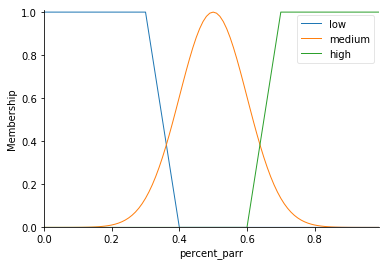

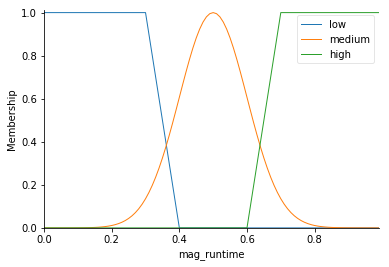

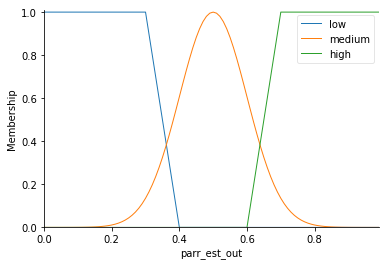

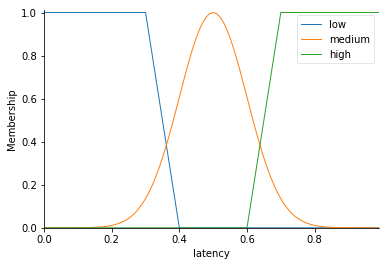

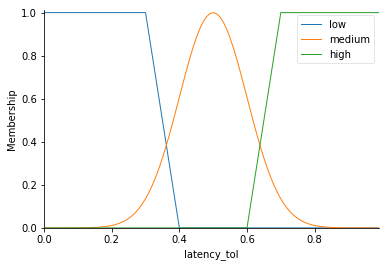

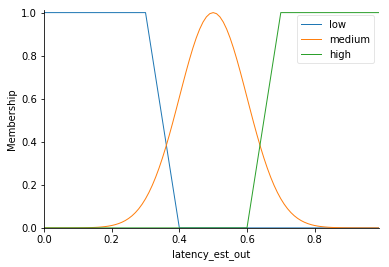

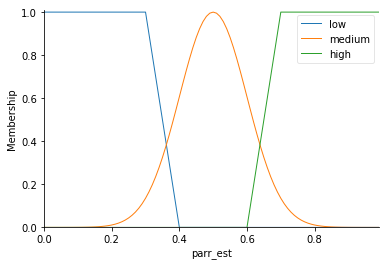

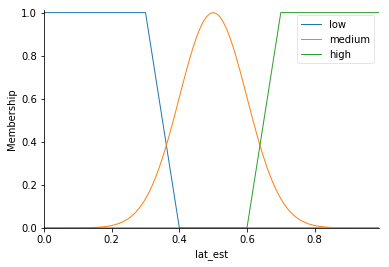

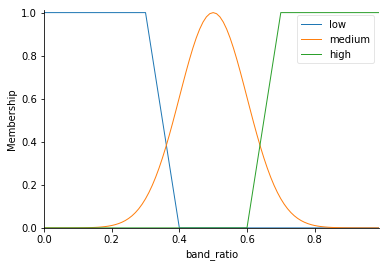

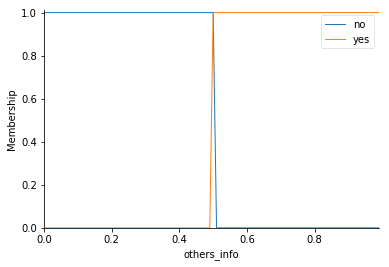

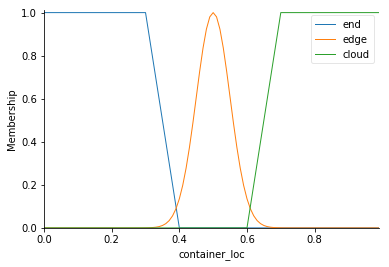

In [5]:
cont_est = ContainerEstimator()

In [6]:
percent_parr = 0.01
run_mag = 150
latency = 50
latency_tol = 0.9
throughput = 100
bandwidth = 1000
others_info = 0.0
location = cont_est.calculate_parr_out(percent_parr,run_mag,latency,latency_tol,throughput,bandwidth,others_info)
print location

Latency effects:  0.17619047619047615
Parr Effects:  0.17619584210064804 0.01 150
0.17773150682246325
